In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.stats import permutation_test
import kcorrect.kcorrect
from astroquery.sdss import SDSS
import matplotlib.gridspec as gridspec


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1)
sns.set_palette("pastel")

# get data

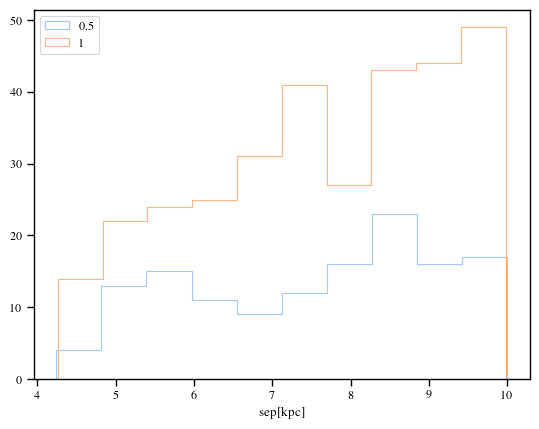

In [2]:
with open("/home/insepien/research-data/df/volonteri22_header.txt", "r") as f:
    d = f.readlines()

colnames = [x[24:34].split()[0] for x in d]
pure05 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z05.txt", delim_whitespace=True, names=colnames)
pure1 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z1.txt", delim_whitespace=True, names=colnames)
#pure0 = pd.read_csv("/home/insepien/research-data/df/volonteri22_z0.txt", delim_whitespace=True, names=colnames)

def calsep(cat):
    return np.sqrt((cat.x1-cat.x2)**2+(cat.y1-cat.y2)**2+(cat.z1-cat.z2)**2)

pure05['sep'] = calsep(pure05)
pure1['sep'] = calsep(pure1)
#pure0['sep'] = calsep(pure0)

fulldf = pd.concat([pure05,pure1])

# plt.hist(pure0.sep,label='0')
plt.hist(pure05.sep,label="0.5",histtype='step')
plt.hist(pure1.sep,label='1',histtype='step')
plt.xlabel("sep[kpc]")
plt.legend();

# measure df

In [3]:
def quart_mask(quant,cuts,ismag=False):
    mask = []
    mask.append(quant<cuts[0])
    if len(cuts)!= 1:
        for i in range(len(cuts)-1):
            mask.append( ( (quant>cuts[i]) & (quant<cuts[i+1]) ) )
    mask.append(quant>cuts[-1])
    if ismag:
        return list(reversed(mask))
    else:
        return mask

def med_diff(rsmall_e,rsmall_l,rbig_e,rbig_l,axis):
    diffbigM = np.median(rbig_e,axis=axis) - np.median(rbig_l,axis=axis)
    diffsmallM = np.median(rsmall_e,axis=axis) - np.median(rsmall_l,axis=axis)
    return diffbigM - diffsmallM


def plot_meh(df_rp,df_z,mass,smallE,smallL,bigE,bigL):
    bigc = 'darkgreen'
    smallc = 'cornflowerblue'

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(4, 3, figure=fig, width_ratios=[2,2.5,1],height_ratios=[0.5,2.5,2.5,0.5])

    # make axes
    ax_hb = fig.add_subplot(gs[1, 0])
    ax_hs = fig.add_subplot(gs[2, 0])
    ax_scat = fig.add_subplot(gs[2:, 1]) 
    ax_histz = fig.add_subplot(gs[1,1])
    ax_histM = fig.add_subplot(gs[2:,2])

    # plot histograms and median lines
    ax_hb.hist(df_rp[bigL],label='bigL',alpha=0.5,color=bigc)
    ax_hb.hist(df_rp[bigE],histtype='step',label='bigE',color=bigc)
    ax_hs.hist(df_rp[smallL],label='smallL',alpha=0.5,color=smallc)
    ax_hs.hist(df_rp[smallE],histtype='step',label='smallE',color=smallc)
    for x,l,ls,c,a in zip([smallE,smallL,bigE,bigL],['smallE', 'smallL', 'bigE', 'bigL'],[":","-",":","-"],[smallc,smallc,bigc,bigc],[ax_hs,ax_hs,ax_hb,ax_hb]):
        a.axvline(np.median(df_rp[x]),label=l,linestyle=ls,color=c)
    # labels
    ax_hs.set_xlim(ax_hb.get_xlim())
    [a.set_xlabel('Sep [kpc]') for a in [ax_hb,ax_hs]]

    # scatter M vs z
    # ax_scat.scatter(df_z, mass,c='k',s=2,alpha=0.4)
    im = [ax_scat.scatter(df_z[mask], mass[mask],c=df_rp[mask]) for mask in [smallE,bigE,smallL,bigL]]
    # labels
    ax_scat.set_xlabel("Z")
    ax_scat.yaxis.set_inverted(True)
    ax_scat.set_xlim(0,np.max(df_z)+0.01)
    ax_scat.set_ylim(np.max(mass)+0.5,np.min(mass)-0.5)

    # histograms along scatter plot
    ax_histz.hist(df_z, color='k',histtype='step')
    ax_histM.hist(mass,orientation='horizontal',color='k',histtype='step')
    ax_histz.set_xlim(ax_scat.get_xlim())
    ax_histM.set_ylim(ax_scat.get_ylim())

    # plot cuts
    [[a.axhline(c,c=clr,alpha=0.5) for c,clr in zip([cutsE[0],cutsE[1]],['g','b'])] for a in  [ax_scat,ax_histM]]

    # colorbar
    fig.colorbar(im[0], ax=ax_histM)
    [a.legend(fontsize=8) for a in [ax_hb,ax_hs,ax_scat]]
    fig.tight_layout();

/tmp/ipykernel_16049/2720637822.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [a.legend(fontsize=8) for a in [ax_hb,ax_hs,ax_scat]]


PermutationTestResult(statistic=-0.033206050253572705, pvalue=0.5065, null_distribution=array([-0.43670346, -0.96592349, -1.03787523, ..., -1.09975423,
       -0.52152766, -1.57861994]))


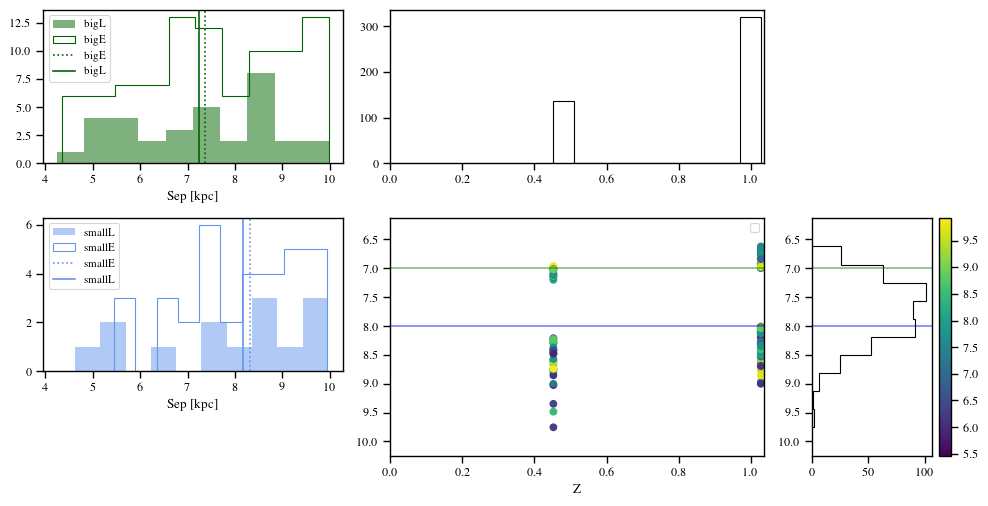

In [45]:
# extract some quantities
mbh = np.array([np.max([i,j]) for i,j in zip(fulldf.logMBH1.values,fulldf.logMBH2.values)])
redshifts = fulldf.z.values
sep = fulldf.sep.values

# z masks
zLate = 1
zEarly = 0.5
early = redshifts > zEarly
late = redshifts < zLate

# max sep cut
sepcutL = sep < 10#(sep > np.percentile(sep[late],10)) & (sep < np.percentile(sep[late],90)) 
sepcutE = sep > 4 #(sep > np.percentile(sep[early],25)) 
sepcutLS = sep < 10
sepcutES = sep > 4

# mass cut
cutsE = np.array([7,8])#np.percentile(mbh,[25,75])
cutsL = cutsE+0.2
massmaskE= quart_mask(mbh,cutsE)
massmaskL = quart_mask(mbh,cutsL)

# composite masks
smallE = massmaskE[0] & early & sepcutES
smallL = massmaskL[0] & late & sepcutLS
bigE = massmaskE[2] & early& sepcutE
bigL = massmaskL[2] & late & sepcutL


plot_meh(fulldf.sep,fulldf.z,mbh,smallE,smallL,bigE,bigL)
seps = [fulldf.sep[m] for m in [smallE,smallL,bigE,bigL]]
print(permutation_test(seps, statistic=med_diff, vectorized=True,alternative='greater'))
